# Imports

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import lab2rgb


In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Mount

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
print(os.listdir("/content/drive/MyDrive"))


['Colab Notebooks', 'How to get started with Drive.pdf', 'Classroom', 'colorization dataset']


# Paths

In [10]:
BASE_PATH = "/content/drive/MyDrive/colorization dataset"

L_PATH = os.path.join(BASE_PATH, "l", "gray_scale.npy")
AB_DIR = os.path.join(BASE_PATH, "ab", "ab")

print("L exists:", os.path.exists(L_PATH))
print("AB exists:", os.path.exists(AB_DIR))


L exists: True
AB exists: True


# Load Arrays

In [11]:
L_all = np.load(L_PATH)            # (N,224,224)

ab_files = sorted(os.listdir(AB_DIR))
ab_list = [np.load(os.path.join(AB_DIR, f)) for f in ab_files]
AB_all = np.concatenate(ab_list, axis=0)   # (N,224,224,2)

print("L_all:", L_all.shape)
print("AB_all:", AB_all.shape)


L_all: (25000, 224, 224)
AB_all: (25000, 224, 224, 2)


# Pre Processing

In [12]:
def preprocess_np(idx):
    L = L_all[idx].astype("float32") / 255.0
    L = L[...,None]           # (224,224,1)

    ab = AB_all[idx].astype("float32") / 128.0
    return L, ab


# RGB

In [13]:
def lab_to_rgb(L, ab):
    L = (L[...,0] * 100).astype("float32")
    ab = (ab * 128).astype("float32")

    lab = np.zeros((224,224,3), dtype="float32")
    lab[...,0] = L
    lab[...,1:] = ab

    return lab2rgb(lab)


# Ground Truth Color

/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 39551 negative Z values that have been clipped to zero
  return lab2rgb(lab)


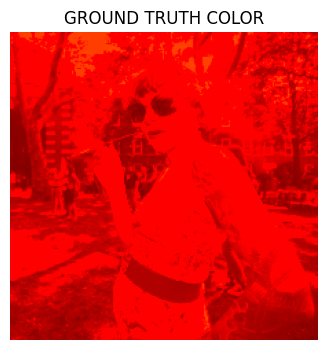

In [15]:
L0, ab0 = preprocess_np(0)
rgb_gt = lab_to_rgb(L0, ab0)

plt.figure(figsize=(4,4))
plt.imshow(rgb_gt)
plt.title("GROUND TRUTH COLOR")
plt.axis("off")
plt.show()


# Split Train

In [16]:
N = L_all.shape[0]

idx = np.arange(N)
np.random.seed(42)
np.random.shuffle(idx)

train_end = int(0.8 * N)
val_end   = int(0.9 * N)

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:", len(test_idx))


Train: 20000 Val: 2500 Test: 2500


# Pipeline

In [17]:
import tensorflow as tf

IMG_SIZE   = 224
BATCH_SIZE = 16  # fast+safe on Colab GPU (try 32 if RAM ok)

def tf_preprocess(i):
    def _py(i_np):
        L, ab = preprocess_np(int(i_np))
        return L.astype("float32"), ab.astype("float32")
    x, y = tf.py_function(_py, [i], [tf.float32, tf.float32])
    x.set_shape((IMG_SIZE, IMG_SIZE, 1))
    y.set_shape((IMG_SIZE, IMG_SIZE, 2))
    return x, y

def make_ds(indices, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(indices)
    if shuffle:
        ds = ds.shuffle(2000)
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_idx, shuffle=True)
val_ds   = make_ds(val_idx, shuffle=False)
test_ds  = make_ds(test_idx, shuffle=False)

for x, y in train_ds.take(1):
    print("X:", x.shape, "Y:", y.shape)


X: (16, 224, 224, 1) Y: (16, 224, 224, 2)


# CNN Model Baseline

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)

    # IMPORTANT: dtype float32 at output (mixed precision safe)
    outputs = layers.Conv2D(2, 1, padding="same", activation="tanh", dtype="float32")(x)
    return keras.Model(inputs, outputs, name="Baseline_CNN")

cnn_model = build_cnn()
cnn_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
cnn_model.summary()


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 112, 112, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 2)    │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 738,626 (2.82 MB)

 Trainable params: 738,626 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN

In [19]:
EPOCHS_CNN = 5
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_CNN)


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 95ms/step - loss: 0.0949 - val_loss: 0.0819
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - loss: 0.0823 - val_loss: 0.0819
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - loss: 0.0827 - val_loss: 0.0819
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 91ms/step - loss: 0.0829 - val_loss: 0.0819
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 114s 92ms/step - loss: 0.0829 - val_loss: 0.0819


# U Net Model

In [21]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
    return x

def build_unet():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

    # Encoder
    c1 = conv_block(inputs, 64);  p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 128);     p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 256);     p3 = layers.MaxPool2D()(c3)

    # Bottleneck
    b  = conv_block(p3, 512)

    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    c4 = conv_block(u3, 256)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c2])
    c5 = conv_block(u2, 128)

    u1 = layers.UpSampling2D()(c5)
    u1 = layers.Concatenate()([u1, c1])
    c6 = conv_block(u1, 64)

    outputs = layers.Conv2D(2, 1, padding="same", activation="tanh", dtype="float32")(c6)
    return keras.Model(inputs, outputs, name="UNet_Colorization")

unet_model = build_unet()
unet_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
unet_model.summary()


Model: "UNet_Colorization"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 224, 224,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_10[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 28,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 28, 28,    │  2,359,808 │ conv2d_12[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 56, 56,    │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 768)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │    590,080 │ conv2d_14[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 112, 112,  │          0 │ conv2d_15[0][0] 

 Total params: 7,781,826 (29.69 MB)

 Trainable params: 7,781,826 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

# Train U Net

In [22]:
EPOCHS_UNET = 20  # increase to 30 for stronger colors if time
history_unet = unet_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_UNET)


Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 349s 202ms/step - loss: nan - val_loss: nan
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 193ms/step - loss: nan - val_loss: nan
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 192ms/step - loss: nan - val_loss: nan
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 193ms/step - loss: nan - val_loss: nan
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 262s 193ms/step - loss: nan - val_loss: nan
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 193ms/step - loss: nan - val_loss: nan
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 263s 193ms/step - loss: nan - val_loss: nan
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 261s 193ms/step - loss: nan - val_loss: nan
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 251s 200ms/step - loss: nan - val_loss: nan
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 193ms/step - loss: nan - val_loss: nan
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 241s 192ms/step - loss: nan - val_loss: nan
Epoch 12/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 250s 200m

# Show Prediction

In [23]:
import random

def show_predictions(model, indices, n=3):
    picks = random.sample(list(indices), min(n, len(indices)))
    plt.figure(figsize=(9, 3*len(picks)))

    for i, idx_ in enumerate(picks):
        L, ab_true = preprocess_np(int(idx_))

        pred_ab = model.predict(L[None,...], verbose=0)[0]  # (224,224,2)

        gray = (L[...,0] * 255).astype("uint8")
        rgb_pred = lab_to_rgb(L, pred_ab)
        rgb_true = lab_to_rgb(L, ab_true)

        plt.subplot(len(picks), 3, 3*i+1)
        plt.imshow(gray, cmap="gray"); plt.title("Input Gray"); plt.axis("off")

        plt.subplot(len(picks), 3, 3*i+2)
        plt.imshow(rgb_pred); plt.title("Predicted Color"); plt.axis("off")

        plt.subplot(len(picks), 3, 3*i+3)
        plt.imshow(rgb_true); plt.title("Ground Truth"); plt.axis("off")

    plt.tight_layout()
    plt.show()


# Results CNN

CNN predictions:


/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40991 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40386 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40256 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40436 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5096 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Con

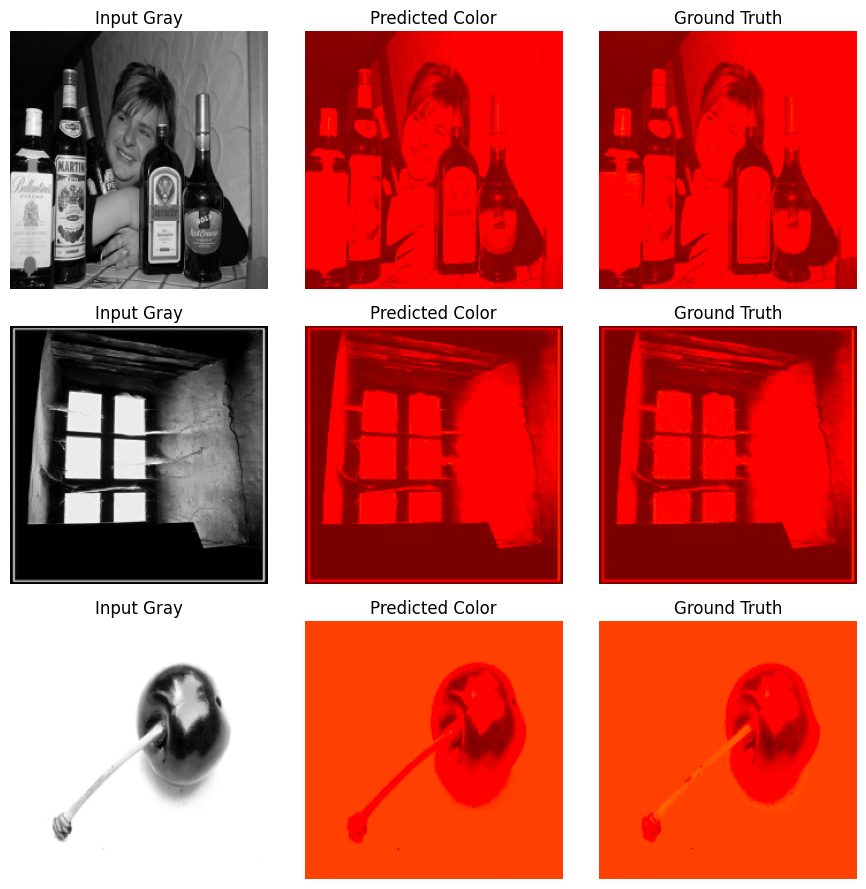

U-Net predictions:


/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25715 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 41999 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 42058 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 41994 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20098 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Co

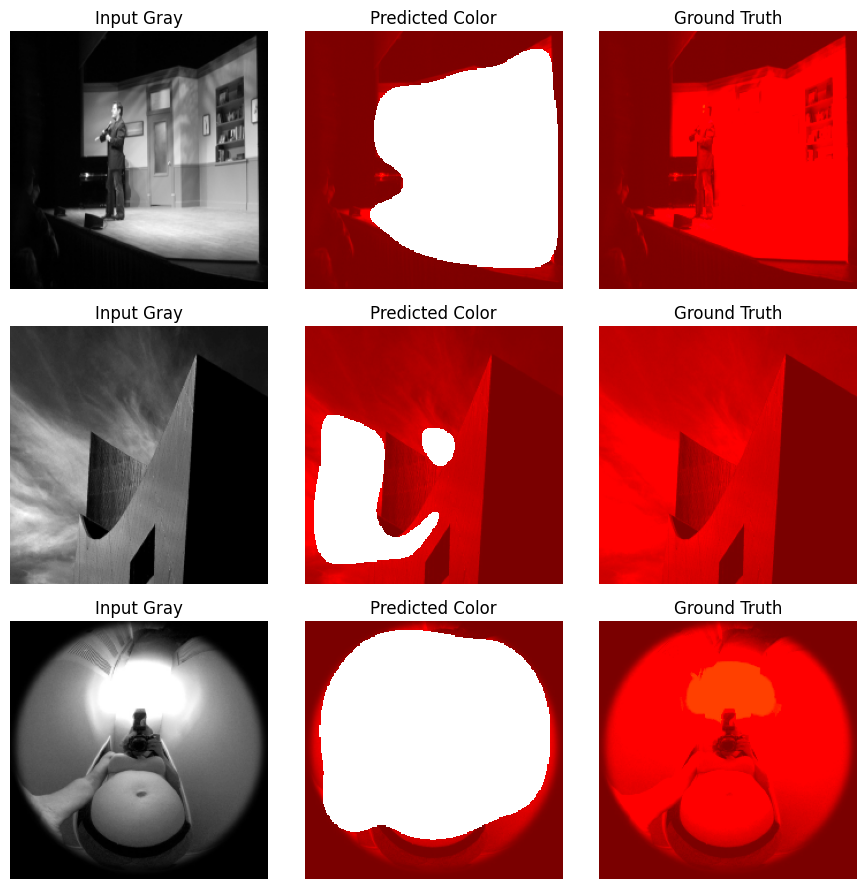

In [24]:
print("CNN predictions:")
show_predictions(cnn_model, test_idx, n=3)

print("U-Net predictions:")
show_predictions(unet_model, test_idx, n=3)


# Results U Net

U-Net predictions:


/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7459 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 26474 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4289 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 32428 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 16679 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conv

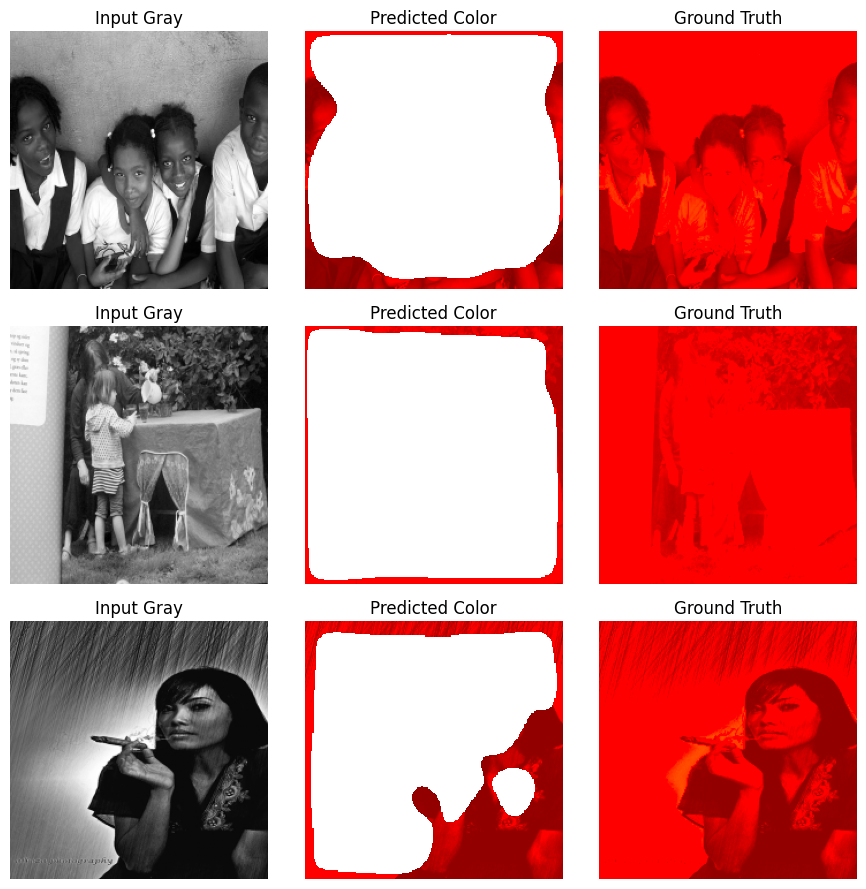

In [26]:
print("U-Net predictions:")
show_predictions(unet_model, test_idx, n=3)


# Comparison

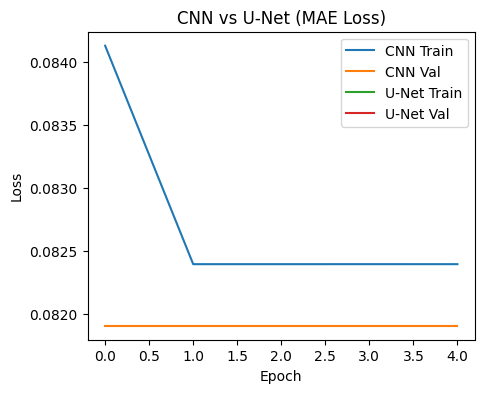

In [28]:
plt.figure(figsize=(5,4))
plt.plot(history_cnn.history["loss"], label="CNN Train")
plt.plot(history_cnn.history["val_loss"], label="CNN Val")
plt.plot(history_unet.history["loss"], label="U-Net Train")
plt.plot(history_unet.history["val_loss"], label="U-Net Val")
plt.title("CNN vs U-Net (MAE Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Save Results to Drive

In [33]:
import cv2, os

out_dir = os.path.join(BASE_PATH, "outputs_unet")
os.makedirs(out_dir, exist_ok=True)

save_n = 20  # save first 20 from test
for k, idx_ in enumerate(list(test_idx)[:save_n]):
    L, _ = preprocess_np(int(idx_))
    pred_ab = unet_model.predict(L[None,...], verbose=0)[0]
    rgb_pred = lab_to_rgb(L, pred_ab)

    # skimage returns float [0..1] sometimes; ensure uint8
    if rgb_pred.max() <= 1.0:
        rgb_pred = (rgb_pred * 255).astype("uint8")

    cv2.imwrite(os.path.join(out_dir, f"pred_{k:03d}.png"), cv2.cvtColor(rgb_pred, cv2.COLOR_RGB2BGR))

print("Saved:", save_n, "images in:", out_dir)


/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 33821 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 15604 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5332 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9887 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 43970 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conv

Saved: 20 images in: /content/drive/MyDrive/colorization dataset/outputs_unet


/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4060 negative Z values that have been clipped to zero
  return lab2rgb(lab)
/tmp/ipython-input-519722295.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 27741 negative Z values that have been clipped to zero
  return lab2rgb(lab)
